#**EDA를 통한 변수 추가 모델**

In [1]:
# 내 드라이브에 대한 주소
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# 내 드라이브에 대한 주소
path = "/content/drive/MyDrive/Colab Notebooks/dacon_news"

train = pd.read_csv(path + "/data/news_train.csv")
#try_train = pd.read_csv("try_title_data.csv")
test = pd.read_csv(path + "/data/news_test.csv")

In [4]:
train.head()

,n_id,date,title,content,ord,info
0,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,[이데일리 MARKETPOINT]15:32 현재 코스닥 기관 678억 순매도,1,0
1,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,"""실적기반"" 저가에 매집해야 할 8월 급등유망주 TOP 5 전격공개",2,1
2,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,"하이스탁론, 선취수수료 없는 월 0.4% 최저금리 상품 출시",3,1
3,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,종합 경제정보 미디어 이데일리 - 무단전재 & 재배포 금지,4,0
4,NEWS09727,20200626,"롯데·공영 등 7개 TV 홈쇼핑들, 동행세일 동참",전국적인 소비 붐 조성에 기여할 예정,1,0


# content 맨앞이 [이거나 (이면 0

In [5]:
train["content_startswith_["]=train.content.apply(lambda x : str(x).startswith("[" ) or str(x).startswith("(") or str(x).startswith("제목"))+0

# 타이틀을 이용한 feature
- 해당 title에 몇가지 단어가 들어갈 경우 약 90% 이상이 info가 1

In [6]:
"""
title_noise = ['적중 100%', '글로벌 주요 뉴스', '[전문가 의견]', 
               '[포커스]', '※','■', '▶' ,'◆','★',' TOP', 'BEST',
'전문가의 눈', '전문가선정', '전문가의견','】','후속주도 감사합니다',
               '전문가추천', '주요이슈']

def title_choose(x):
  if ("종목" in x["title"][-6:]) or ("관련주" in x["title"][-5:]):
    return 1
  elif ('00%' in x["content"]) or (x["content"]=="코스피") or (x["content"]=="코스닥"):
    return 1
  elif ('TOP' in x["content"].upper()) or ('BEST' in x["content"].upper()):
    return 1
  for noise in title_noise:
    if noise in x["title"].upper():
      if (x["content"][:2]=="제목") or (x["content"][:1]=="["):
        return 0
      else:
        return 1
  return 0
"""

'\ntitle_noise = [\'적중 100%\', \'글로벌 주요 뉴스\', \'[전문가 의견]\', \n               \'[포커스]\', \'※\',\'■\', \'▶\' ,\'◆\',\'★\',\' TOP\', \'BEST\',\n\'전문가의 눈\', \'전문가선정\', \'전문가의견\',\'】\',\'후속주도 감사합니다\',\n               \'전문가추천\', \'주요이슈\']\n\ndef title_choose(x):\n  if ("종목" in x["title"][-6:]) or ("관련주" in x["title"][-5:]):\n    return 1\n  elif (\'00%\' in x["content"]) or (x["content"]=="코스피") or (x["content"]=="코스닥"):\n    return 1\n  elif (\'TOP\' in x["content"].upper()) or (\'BEST\' in x["content"].upper()):\n    return 1\n  for noise in title_noise:\n    if noise in x["title"].upper():\n      if (x["content"][:2]=="제목") or (x["content"][:1]=="["):\n        return 0\n      else:\n        return 1\n  return 0\n'

In [7]:
title_noise = ['적중 100%', '글로벌 주요 뉴스', '[전문가 의견]', 
               '[포커스]', '※','■', '▶' ,'◆','★',' TOP', 'BEST',
'전문가의 눈', '전문가선정', '전문가의견','】','후속주도 감사합니다',
               '전문가추천', '주요이슈']

def title_choose(x):
  if ("종목" in x[-6:]) or ("관련주" in x[-5:]):
    return 1
  for noise in title_noise:
    if noise in x.upper():
        return 1
  return 0

In [8]:
train["info1_title"]=train["title"].apply(title_choose)

# content를 이용한 feature

In [9]:
content_noise = ['00%', '긴급공개', '긴급 공개','임상3상', 'TOP','BEST','# ','+','..', '카톡','대장','원"만']

def content_choose(x):
  if (x=='관련기사') or (x=="관련 테마분석") or (x=="코스피") or (x=="코스닥"):
    return 1
  for noise in content_noise:
    if noise in x.upper():
        return 1
  return 0

In [10]:
train["info1_content"]=train["content"].apply(content_choose)

# info가 1인 content에서 자주 등장하는 단어를 포함한 content를 1로하는 feature 추가

In [11]:
"""
def in_bull(x):
    info_list = ['공개','추천','상한','무료','주식','바이오','금리','테마','탁론','카톡','실적',
                 '수익', '미수', '수혜주','급등', 'http', '하이스',"]]"]
    for i in info_list:
        if i in x:
            return 1
    return 0
train["info1_words"]=train["content"].apply(in_bull)
"""

'\ndef in_bull(x):\n    info_list = [\'공개\',\'추천\',\'상한\',\'무료\',\'주식\',\'바이오\',\'금리\',\'테마\',\'탁론\',\'카톡\',\'실적\',\n                 \'수익\', \'미수\', \'수혜주\',\'급등\', \'http\', \'하이스\',"]]"]\n    for i in info_list:\n        if i in x:\n            return 1\n    return 0\ntrain["info1_words"]=train["content"].apply(in_bull)\n'

# Order을 이용한 feature

In [12]:
title_group = (train.groupby(["title"]).count())["n_id"]
train["new_ord"]=train.apply(lambda x: x["ord"]/title_group[x["title"]], axis=1)

# tokenization

In [14]:
# konlpy Mecab 사용하기

!set -x \
&& pip install konlpy \
&& curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh | bash -x

+ pip install konlpy
     |████████████████████████████████| 19.4MB 1.3MB/s 
     |████████████████████████████████| 92kB 8.5MB/s 
     |████████████████████████████████| 460kB 41.1MB/s 
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
+ curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh
+ bash -x
+ mecab_dicdir=/usr/local/lib/mecab/dic/mecab-ko-dic
+ set -e
++ uname
+ os=Linux
+ [[ ! Linux == \L\i\n\u\x ]]
+ hash sudo
+ sudo=sudo
+ python=python3
+ hash pyenv
+ at_user_site=
++ check_python_site_location_is_writable
++ python3 -
+ [[ 1 == \0 ]]
+ hash automake
+ echo 'Installing automake (A dependency for mecab-ko)'
Installing automake (A dependency for mecab-ko)
+ install_automake
+ '[' Linux == Linux ']'
++ grep -Ei 'debian|buntu|mint' /etc/lsb-

In [15]:
from konlpy.tag import Mecab
import re

def text_preprocessing(text_list):
    
    stopwords = [] #불용어 설정
    
    tokenizer = Mecab() #형태소 분석기 
    token_list = [] 
    
    for text in text_list:
        txt = re.sub('[^가-힣]', ' ', text) #한글만 남기고 다른 글자 모두 제거
        txt = re.sub('[가-힣\s]+기자]','기자', txt) #기자 이름 제거
        token = tokenizer.morphs(txt) #형태소 분석

        #형태소 분석 결과 중 stopwords에 해당하지 않고, float type이 아닌 것만 수집
        token = [t for t in token] 
        token_list.append(token)
        
    return token_list, tokenizer

#형태소 분석기를 따로 저장한 이유는 후에 test 데이터 전처리를 진행할 때 이용해야 되기 때문입니다. 
train['new_article'], okt = text_preprocessing(train['content'])

In [16]:
# 결측치 제거
train = train[train["new_article"].apply(lambda x: False if len(x)==0 else True)]

In [17]:
train.head()

,n_id,date,title,content,ord,info,content_startswith_[,info1_title,info1_content,new_ord,new_article
0,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,[이데일리 MARKETPOINT]15:32 현재 코스닥 기관 678억 순매도,1,0,1,0,0,0.250000,"[이, 데일리, 현재, 코스닥, 기관, 억, 순매도]"
1,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,"""실적기반"" 저가에 매집해야 할 8월 급등유망주 TOP 5 전격공개",2,1,0,0,1,0.500000,"[실적, 기반, 저가, 에, 매집, 해야, 할, 월, 급등, 유망주, 전격, 공개]"
2,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,"하이스탁론, 선취수수료 없는 월 0.4% 최저금리 상품 출시",3,1,0,0,0,0.750000,"[하이스, 탁론, 선취, 수수료, 없, 는, 월, 최저, 금리, 상품, 출시]"
3,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,종합 경제정보 미디어 이데일리 - 무단전재 & 재배포 금지,4,0,0,0,0,1.000000,"[종합, 경제, 정보, 미디어, 이, 데, 일리, 무단, 전재, 재, 배포, 금지]"
4,NEWS09727,20200626,"롯데·공영 등 7개 TV 홈쇼핑들, 동행세일 동참",전국적인 소비 붐 조성에 기여할 예정,1,0,0,0,0,0.066667,"[전국, 적, 인, 소비, 붐, 조성, 에, 기여, 할, 예정]"


# Vectorization

In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_len = 20

def text2sequence(train_text, max_len=100):
    
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train_text)
    train_X_seq = tokenizer.texts_to_sequences(train_text)
    vocab_size = len(tokenizer.word_index) + 1
    print('vocab_size : ', vocab_size)
    X_train = pad_sequences(train_X_seq, maxlen = max_len, truncating="post") # 길이를 맞춰줌
    return X_train, vocab_size, tokenizer

train_y = train['info']
train_X, vocab_size, vectorizer = text2sequence(train['new_article'], max_len = max_len)

print(train_X.shape, train_y.shape)

# train_X new_article을 vectorizer

vocab_size :  33461
(118414, 20) (118414,)


# Word2Vec

In [19]:
import gensim
from gensim.models.keyedvectors import KeyedVectors

In [20]:
"""
# 구글 word2vec 모델

word2vec_g = gensim.models.KeyedVectors.load_word2vec_format(path+'embedding/GoogleNews-vectors-negative300.bin.gz', binary = True)
embedding_size = 300
"""

"\n# 구글 word2vec 모델\n\nword2vec_g = gensim.models.KeyedVectors.load_word2vec_format(path+'embedding/GoogleNews-vectors-negative300.bin.gz', binary = True)\nembedding_size = 300\n"

In [21]:
# 한국어 word2vec model
word2vec2 = gensim.models.Word2Vec.load(path+'/embedding/ko.bin')
embedding_size = 200


In [22]:
embedding_matrix = np.zeros((vocab_size, embedding_size))
vocab = vectorizer.word_index
count = 0

for idx, word in enumerate(vocab):
    if word in word2vec2:
      embedding_vector = word2vec2[word]
      embedding_matrix[idx] = embedding_vector
    else: # 임베딩 모델에 없는 것
      #print(word, "word2vec에 없는 단어입니다.")
      count += 1
      pass

print('count: ', count)  

count:  17728


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


#train test split

In [23]:
#concat
feature_num = 4
train_X = np.concatenate([train_X,train[["info1_title","info1_content","new_ord","content_startswith_["]].values.reshape(-1,feature_num)], axis=1)
train_X

# 문장별로 train_test set 분리
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_y, random_state = 42, test_size = 0.3)

In [24]:
index_seq = (X_train.argmax(axis=1)).argsort(axis=0)  # 최대값 index를 반환하여 arry 정렬
X_train = X_train[index_seq]
y_train = y_train.iloc[index_seq]

In [25]:
index_seq

array([ 6009, 47753, 20993, ..., 58911, 58874, 16184])

# stacking 모델링
 GradientBoost,  AdaBoost, CatBoost, ExtraTree

In [50]:
pip install catboost

     |████████████████████████████████| 65.8MB 108kB/s 


In [97]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
import catboost
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold



In [27]:

# def auc(m, train, test): 
#     return (metrics.roc_auc_score(y_train,m.predict_proba(train)[:,1]),
#                            metrics.roc_auc_score(y_test,m.predict_proba(test)[:,1]))
    
    
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    

## GradientBoost

In [136]:
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier(random_state = 42) # 기본값: max_depth=3, learning_rate=0.1
gb_clf.fit(X_train, y_train)


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [137]:
gb_pred = gb_clf.predict(X_valid)

gb_acc = accuracy_score(y_valid, gb_pred)
gb_acc

0.9736242083040113

In [138]:
gbm_params = {
    'n_estimators' : [100, 500, 1000],
    'learning_rate' : [0.001, 0.01, 0.1],
}


gb_grid = GridSearchCV(gb_clf, param_grid = gbm_params, cv = 3)
gb_grid.fit(X_train, y_train)

print('최적 하이퍼 파라미터:\n', gb_grid.best_params_)
print('최고 예측 정확도: {0:.6f}'.format(gb_grid.best_score_))

KeyboardInterrupt: ignored

In [32]:
gb_pred = gb_grid.best_estimator_.predict(X_valid)

gb_acc = accuracy_score(y_valid, gb_pred)
gb_acc


0.9736242083040113

In [33]:
gb_pred

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

In [34]:
gb_valid_pred = pd.DataFrame(gb_pred, columns =['GradientBoosting'])
gb_valid_pred

,GradientBoosting
0,1
1,0
2,1
3,1
4,1
...,...
35520,1
35521,0
35522,1
35523,1


In [46]:
# submit

gb_valid_pred.to_csv("gb_valid_pred.csv", encoding="utf-8-sig",index=False)

### AdaBoost

- n_estimators를 늘린다면

생성하는 weak learner의 수는 늘어남

이 여러 학습기들의 decision boundary가 많아지면서 모델이 복잡해짐

- learning_rate을 줄인다면

가중치 갱신의 변동폭이 감소해서, 여러 학습기들의 decision boundary 차이가 줄어듦

- n_estimoatrs와 learning_Rate는 trade-off 관계
n_estimators(또는 learning_rate)를 늘리고, learning_rate(또는 n_estimators)을 줄인다면 서로 효과가 상쇄됌.

→ 두 파라미터를 잘 조정하는 것이 알고리즘의 핵심.

In [61]:
DTC = DecisionTreeClassifier(max_depth = 1, random_state=42)

ada_clf = AdaBoostClassifier(base_estimator = DTC, random_state=42) # default: estimators = 50, lr =1
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [41]:
ada_pred = ada_clf.predict(X_valid)
ada_acc = accuracy_score(y_valid, ada_pred)
ada_acc


0.9564250527797326

In [42]:
ada_params = {
    'n_estimators' : [50, 100, 500, 1000],
    'learning_rate' : [0.001, 0.01, 0.1, 1],
}


ada_grid = GridSearchCV(ada_clf, param_grid = ada_params, cv = 3)
ada_grid.fit(X_train, y_train)

print('최적 하이퍼 파라미터:\n', ada_grid.best_params_)
print('최고 예측 정확도: {0:.6f}'.format(ada_grid.best_score_))

최적 하이퍼 파라미터:
 {'learning_rate': 0.1, 'n_estimators': 1000}
최고 예측 정확도: 0.887246


In [43]:
# predict
ada_pred = ada_grid.best_estimator_.predict(X_valid)

ada_acc = accuracy_score(y_valid, ada_pred)
ada_acc


0.9610133708655876

In [44]:
ada_valid_pred = pd.DataFrame(ada_pred, columns =['AdaBoost'])
ada_valid_pred

,AdaBoost
0,1
1,0
2,1
3,1
4,1
...,...
35520,1
35521,0
35522,1
35523,1


In [45]:
# submit

ada_valid_pred.to_csv("ada_valid_pred.csv", encoding="utf-8-sig",index=False)

### catBoost

In [83]:
cb_clf = CatBoostClassifier(random_state=42)
cb_clf.fit(X_train, y_train)

cb_pred = cb_clf.predict(X_valid)


Learning rate set to 0.067941
0:	learn: 0.5842131	total: 59.9ms	remaining: 59.9s
1:	learn: 0.4997175	total: 107ms	remaining: 53.4s
2:	learn: 0.4341391	total: 170ms	remaining: 56.4s
3:	learn: 0.3867128	total: 220ms	remaining: 54.9s
4:	learn: 0.3459648	total: 266ms	remaining: 53s
5:	learn: 0.3166771	total: 313ms	remaining: 51.8s
6:	learn: 0.2916814	total: 357ms	remaining: 50.7s
7:	learn: 0.2648083	total: 404ms	remaining: 50.2s
8:	learn: 0.2480252	total: 456ms	remaining: 50.2s
9:	learn: 0.2295846	total: 508ms	remaining: 50.3s
10:	learn: 0.2186249	total: 552ms	remaining: 49.6s
11:	learn: 0.2054137	total: 597ms	remaining: 49.2s
12:	learn: 0.1963938	total: 646ms	remaining: 49.1s
13:	learn: 0.1867291	total: 699ms	remaining: 49.2s
14:	learn: 0.1808226	total: 748ms	remaining: 49.1s
15:	learn: 0.1743656	total: 793ms	remaining: 48.7s
16:	learn: 0.1697262	total: 843ms	remaining: 48.7s
17:	learn: 0.1640188	total: 888ms	remaining: 48.4s
18:	learn: 0.1584289	total: 939ms	remaining: 48.5s
19:	learn: 0

In [84]:
cb_pred

array([1, 0, 1, ..., 1, 1, 1])

In [85]:
cb_acc = accuracy_score(y_valid, cb_pred)
cb_acc

0.9875017593244194

In [88]:
cb_valid_pred = pd.DataFrame(cb_pred, columns =['catboost'])
cb_valid_pred

,catboost
0,1
1,0
2,1
3,1
4,1
...,...
35520,1
35521,0
35522,1
35523,1


In [89]:
# submit

cb_valid_pred.to_csv("cb_valid_pred.csv", encoding="utf-8-sig",index=False)

cb_params = {
    'n_estimators' : [100, 500, 1000],
    'learning_rate' : [0.001, 0.01, 0.1],
}


grid_cv = GridSearchCV(cb_clf, param_grid = cb_params, cv = 3)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.6f}'.format(grid_cv.best_score_))

- 최적 하이퍼 파라미터:
 {'learning_rate': 0.1, 'n_estimators': 100}
  최고 예측 정확도: 0.887512


- valid - acc = 0.9797607318789585

### ExtraTree

In [76]:
ext_clf =  ExtraTreesClassifier(random_state=42)
ext_clf.fit(X_train, y_train)

#default n_estimators = 100, max_depth=None

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=42, verbose=0,
                     warm_start=False)

In [77]:

ext_pred = ext_clf.predict(X_valid)
ext_acc = accuracy_score(y_valid, ext_pred)
ext_acc


0.9818437719915553

In [81]:
ext_params = {
    'n_estimators' : [100, 500, 1000]
}


ext_cv = GridSearchCV(ext_clf, param_grid = ext_params, cv = 3)
ext_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터:\n', ext_cv.best_params_)
print('최고 예측 정확도: {0:.6f}'.format(ext_cv.best_score_))

최적 하이퍼 파라미터:
 {'n_estimators': 1000}
최고 예측 정확도: 0.872251


In [91]:
grid_cv.get_params

<bound method BaseEstimator.get_params of GridSearchCV(cv=3, error_score=nan,
             estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                            class_weight=None, criterion='gini',
                                            max_depth=None, max_features='auto',
                                            max_leaf_nodes=None,
                                            max_samples=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=100, n_jobs=None,
                                            oob_score=False, random_state=42,
                                            verbose=0, warm_s

In [90]:
# predict
ext_pred = ext_cv.best_estimator_.predict(X_valid)

ext_acc = accuracy_score(y_valid, ext_pred)
ext_acc

0.9823786066150598

In [92]:
ext_valid_pred = pd.DataFrame(ext_pred, columns =['ExtraTree'])
ext_valid_pred


,ExtraTree
0,1
1,0
2,1
3,1
4,1
...,...
35520,1
35521,0
35522,1
35523,1


In [93]:
# submit

ext_valid_pred.to_csv("ext_valid_pred.csv", encoding="utf-8-sig",index=False)

### 스태킹

In [224]:
# 아래 LSTM_add_feature()로 만든 예측값

lstm_pred1 

array([0.99867976, 0.00227535, 0.9995058 , ..., 0.99998546, 0.9999975 ,
       0.9999955 ], dtype=float32)

In [212]:
all_pred = np.array([gb_pred, ada_pred, cb_pred, ext_pred, lstm_pred1])
all_pred.shape

(5, 35525)

In [213]:
all_pred = np.transpose(all_pred)
all_pred.shape

(35525, 5)

In [214]:
lgbm_clf=LGBMClassifier(random_state=42)
lgbm_clf.fit(all_pred, y_valid)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [215]:

lgbm_pred = lgbm_clf.predict(all_pred)
lgbm_acc = accuracy_score(y_valid, lgbm_pred)
lgbm_acc


0.9929627023223082

In [216]:
lgbm_params={'boosting':['gbdt'],
               'objective':['binary'],
               'learning_rate':[0.001,0.05,0.1],
               'max_depth':[2,4,6,8],
               'n_estimators':[100,500,1000]}

grid_lgbm = GridSearchCV(lgbm_clf,param_grid=lgbm_params,cv=3)
grid_lgbm.fit(all_pred,y_valid)


print('최적 하이퍼 파라미터:\n', grid_lgbm.best_params_)
print('최고 예측 정확도: {0:.6f}'.format(grid_lgbm.best_score_))

최적 하이퍼 파라미터:
 {'boosting': 'gbdt', 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100, 'objective': 'binary'}
최고 예측 정확도: 0.992484


In [217]:
stacking_pred=grid_lgbm.predict(all_pred)
stacking_pred


array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

In [218]:
stacking_acc = accuracy_score(y_valid, stacking_pred)
stacking_acc

0.9925967628430683

In [219]:
stacking_valid_pred = pd.DataFrame(ext_pred, columns =['gb, cb'])
stacking_valid_pred


,"gb, cb"
0,1
1,0
2,1
3,1
4,1
...,...
35520,1
35521,0
35522,1
35523,1


In [108]:
# submit

stacking_valid_pred.to_csv("stacking_valid_pred.csv", encoding="utf-8-sig",index=False)

#모델링

In [177]:
# EDA기반으로 만든 feature 예측변수로 추가
from keras import regularizers

def LSTM_add_feature(vocab_size, embedding_size = 100, max_len=100):
  input1 = keras.layers.Input(shape = [max_len,]) #문장 단어 input
  input2 = keras.layers.Input(shape = [feature_num,]) # EDA기반 feature input

  # LSTM
  embedding = keras.layers.Embedding(vocab_size, embedding_size, weights = [embedding_matrix], input_length = max_len)(input1) # 임베딩 가중치 적용
  dropout1 = keras.layers.SpatialDropout1D(0.3)(embedding)
  lstm1 = keras.layers.LSTM(32, return_sequences = True)(dropout1)
  lstm2 = keras.layers.LSTM(32)(lstm1)
  dropout2 = keras.layers.Dropout(0.5)(lstm2)
  #lstm_output = keras.layers.Dense(16, activation = "selu")(dropout2)

  # MLP
  concat = keras.layers.concatenate([dropout2,input2])
  hidden = keras.layers.Dense(32, activation = "selu")(concat)
  output = keras.layers.Dense(1, activation = "sigmoid")(hidden)

  model = keras.Model(inputs = [input1, input2], outputs = [output])

  model.compile(optimizer=keras.optimizers.Adam(lr=learning_rate), loss="binary_crossentropy", metrics = "accuracy")
  model.summary()
  return model


In [178]:
# 훈련 시
tf.random.set_seed(42)


checkpoint_cb = keras.callbacks.ModelCheckpoint("hyerim_add_feature_best_model2.h5",
                                               save_best_only = True)

# 하이퍼파라미터
max_epoch = 5
batch_size = 32
learning_rate = 0.001

model = LSTM_add_feature(vocab_size, max_len = max_len, embedding_size = embedding_size)
history = model.fit(x=[X_train[:,:max_len],X_train[:,-feature_num:]], y=y_train, epochs=max_epoch,
                batch_size = batch_size,  validation_data = ((X_valid[:,:max_len],X_valid[:,-feature_num:]),y_valid), validation_batch_size = batch_size,
                 callbacks = [checkpoint_cb])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 20, 200)      6692200     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 20, 200)      0           embedding[0][0]                  
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 20, 32)       29824       spatial_dropout1d[0][0]          
______________________________________________________________________________________________

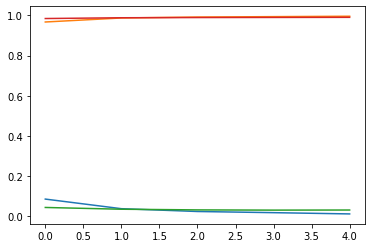

In [182]:
best_model = keras.models.load_model("hyerim_add_feature_best_model2.h5") # 저장된 모델 불러오기
plt.plot(pd.DataFrame(history.history)) # 0.0249 0.0211

In [185]:
# 성능
best_model.evaluate((X_valid[:,:-feature_num],X_valid[:,-feature_num:]),y_valid)

1111/1111 [==============================] - 7s 6ms/step - loss: 0.0317 - accuracy: 0.9901


[0.031701769679784775, 0.9900633096694946]

In [187]:
lstm_pred = best_model.predict((X_valid[:,:-feature_num],X_valid[:,-feature_num:]))
lstm_pred

array([[0.99867976],
       [0.00227535],
       [0.9995058 ],
       ...,
       [0.99998546],
       [0.9999975 ],
       [0.9999955 ]], dtype=float32)

In [220]:
lstm_pred1 = lstm_pred.reshape(-1)
lstm_pred1.shape

(35525,)

In [222]:
lstm_valid_pred = pd.DataFrame(lstm_pred1, columns =['LSTM'])
lstm_valid_pred


,LSTM
0,9.986798e-01
1,2.275348e-03
2,9.995058e-01
3,9.999931e-01
4,9.999966e-01
...,...
35520,9.999999e-01
35521,4.399330e-07
35522,9.999855e-01
35523,9.999975e-01


In [223]:
# submit

lstm_valid_pred.to_csv("lstm_valid_pred.csv", encoding="utf-8-sig",index=False)

# 최종 훈련

In [ ]:
# 실제 예측시
index_seq = (train_X.argmax(axis=1)).argsort(axis=0)
train_X = train_X[index_seq]
train_y = train_y.iloc[index_seq]


tf.random.set_seed(40)

# 하이퍼파라미터
max_epoch = 2
batch_size = 32
learning_rate = 0.001

model = LSTM_add_feature(vocab_size, max_len = max_len)
history = model.fit(x=[train_X[:,:-feature_num],train_X[:,-feature_num:]], y=train_y,epochs=max_epoch,batch_size = batch_size)

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 20, 200)      6692200     input_32[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_12 (SpatialDr (None, 20, 200)      0           embedding_12[0][0]               
__________________________________________________________________________________________________
lstm_24 (LSTM)                  (None, 20, 32)       29824       spatial_dropout1d_12[0][0]       
___________________________________________________________________________________________

In [ ]:
model.save("final_model_99.2.h5")

In [ ]:
final_model = keras.models.load_model("final_model_99.2.h5")

In [ ]:
train_predicted = final_model.predict((train_X[:,:max_len],train_X[:,-feature_num:]))

# 각 문장의 바로 앞문장과, 그 앞 문장의 예측값 생성
train_pre_predicted1 = np.array([train_predicted[idx-1][0] for idx in range(len(train_predicted))]).reshape(-1,1) # 앞문장
train_pre_predicted2 = np.array([train_predicted[idx-2][0] for idx in range(len(train_predicted))]).reshape(-1,1) # 앞앞문장
train_pre_predicted3 = np.array([train_predicted[idx-3][0] for idx in range(len(train_predicted))]).reshape(-1,1) # 앞앞앞문장

In [ ]:
# ord가 1이면 과거 1년도, 2년도 자기값으로 대체
# ord가 2이면 과거 2년도 자기값으로 대체

train["predicted"]=train_predicted
train["pre_predicted1"]=train_pre_predicted1
train["pre_predicted2"]=train_pre_predicted2

train.loc[train["ord"]==1,"pre_predicted1"]=train_predicted[train["ord"]==1]
train.loc[train["ord"]==1,"pre_predicted2"]=train_predicted[train["ord"]==1]
train.loc[train["ord"]==2,"pre_predicted2"]=train_predicted[train["ord"]==2]

In [ ]:
# tree 모델 불러오기
import pickle
import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# xgb model 예측
xgb_model=XGBClassifier(random_state=42)
lgbm_model=LGBMClassifier(random_state=42)

with open(path+'model/new_xgb_model.pkl', 'wb') as f:
  pickle.dump(xgb_model, f)
with open(path+'model/lgbm_model.pkl','wb') as f:
  pickle.dump(lgbm_model,f)

xgb_model.fit(train[["predicted","pre_predicted1","pre_predicted2"]], y=train["info"])
lgbm_model.fit(train[["predicted","pre_predicted1","pre_predicted2"]], y=train["info"])

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
def Lag_MLP():
  model = keras.models.Sequential([
    keras.layers.Dense(16, input_shape = (3,)),
    keras.layers.Dense(1)                
  ])
  model.compile(optimizer=keras.optimizers.Adam(lr=learning_rate), loss="binary_crossentropy", metrics = "accuracy")
  model.summary()
  return model

In [ ]:
# 시퀀셜 LSTM 모델

def Lag_RNN():
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=(3,1)))
    model.add(keras.layers.SimpleRNN(32))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')
    model.summary()
    return model

In [ ]:
# 하이퍼파라미터
tf.random.set_seed(42)

max_epoch = 5
batch_size = 32
learning_rate = 0.001

lag_model = Lag_RNN()
lag_model.fit(x=train[:82858][["predicted","pre_predicted1","pre_predicted2"]].values.reshape(-1,3,1), y=train[:82858]["info"],
              validation_data = (train[82858:][["predicted","pre_predicted1","pre_predicted2"]].values.reshape(-1,3,1),train[82858:]["info"]), batch_size = 16,
              epochs = max_epoch)

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_7 (SimpleRNN)     (None, 32)                1088      
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 33        
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
5179/5179 [==============================] - 12s 2ms/step - loss: 0.0471 - accuracy: 0.9914 - val_loss: 0.0027 - val_accuracy: 0.9997
Epoch 2/5
5179/5179 [==============================] - 12s 2ms/step - loss: 0.0140 - accuracy: 0.9968 - val_loss: 0.0021 - val_accuracy: 0.9996
Epoch 3/5
5179/5179 [==============================] - 12s 2ms/step - loss: 0.0112 - accuracy: 0.9977 - val_loss: 0.0019 - val_accuracy: 0.9996
Epoch 4/5
5179/5179 [==============================] - 12s 2ms/step - loss: 0.014

In [ ]:
# 하이퍼파라미터
tf.random.set_seed(42)

max_epoch = 5
batch_size = 32
learning_rate = 0.0001

lag_model = Lag_MLP()
lag_model.fit(x=train[:82858][["predicted","pre_predicted1","pre_predicted2"]], y=train[:82858]["info"],
              validation_data = (train[82858:][["predicted","pre_predicted1","pre_predicted2"]],train[82858:]["info"]), batch_size = batch_size,
              epochs = max_epoch, validation_batch_size = batch_size)

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 16)                64        
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 17        
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
2590/2590 [==============================] - 4s 1ms/step - loss: 0.1080 - accuracy: 0.9517 - val_loss: 0.0027 - val_accuracy: 0.9995
Epoch 2/5
2590/2590 [==============================] - 4s 1ms/step - loss: 0.0168 - accuracy: 0.9961 - val_loss: 0.0019 - val_accuracy: 0.9995
Epoch 3/5
2590/2590 [==============================] - 4s 1ms/step - loss: 0.0132 - accuracy: 0.9968 - val_loss: 0.0017 - val_accuracy: 0.9995
Epoch 4/5
2590/2590 [==============================] - 4s 1ms/step - loss: 0.0212 - accura

# test 예측

In [ ]:
path = "/gdrive/My Drive/dacon_news/"
feature_num = 4
test = pd.read_csv(path+"data/news_test.csv")

# EDA 기반 feature 추가
test["info1_title"]=test["title"].apply(title_choose)
test["info1_content"]=test["content"].apply(content_choose)
test["content_startswith_["]=test.content.apply(lambda x : str(x).startswith("[" ) or str(x).startswith("(") or str(x).startswith("제목"))+0
title_group = (test.groupby(["title"]).count())["n_id"]
test["new_ord"]=test.apply(lambda x: x["ord"]/title_group[x["title"]], axis=1)
#test["info1_words"]=test["content"].apply(in_bull)

# 전처리
test['new_article'], okt = text_preprocessing(test['content'])
test_X_seq = vectorizer.texts_to_sequences(test["new_article"])
test_X = pad_sequences(test_X_seq, maxlen = max_len) # 길이를 맞춰줌

# concat
test_X = np.concatenate([test_X,test[["info1_title","info1_content","new_ord","content_startswith_["]].values.reshape(-1,feature_num)], axis=1)

In [ ]:
#final_model = keras.models.load_model(path+"model/final_model_99_epoch2.h5") # 저장된 모델 불러오기
final_model = keras.models.load_model("final_model_99.2.h5")
predicted = final_model.predict([test_X[:,:max_len],test_X[:,-feature_num:]])

In [ ]:
# idx-1의 예측값
pre_predicted1 = np.array([predicted[idx-1][0] for idx in range(len(predicted))]).reshape(-1,1)
pre_predicted2 = np.array([predicted[idx-2][0] for idx in range(len(predicted))]).reshape(-1,1)

test["predicted"]=predicted
test["pre_predicted1"]=pre_predicted1
test["pre_predicted2"]=pre_predicted2

# ord가 1이면 과거 1년도, 2년도 자기값으로 대체
# ord가 2이면 과거 2년도 자기값으로 대체
test.loc[test["ord"]==1,"pre_predicted1"]=predicted[test["ord"]==1]
test.loc[test["ord"]==1,"pre_predicted2"]=predicted[test["ord"]==1]
test.loc[test["ord"]==2,"pre_predicted2"]=predicted[test["ord"]==2]

In [ ]:
xgb_final_predicted = xgb_model.predict(test[["predicted","pre_predicted1"]])
lgbm_final_predicted = lgbm_model.predict(test[["predicted","pre_predicted1"]])

In [ ]:
xgb_final_predicted = xgb_model.predict(test[["predicted","pre_predicted1","pre_predicted2"]])
lgbm_final_predicted = lgbm_model.predict(test[["predicted","pre_predicted1","pre_predicted2"]])

In [ ]:
wrong = test[(xgb_final_predicted)!=(lgbm_final_predicted)]

In [ ]:
wrong["xgb_predicted"]=xgb_final_predicted[xgb_final_predicted!=lgbm_final_predicted]
wrong["lgbm_predicte"]=lgbm_final_predicted[xgb_final_predicted!=lgbm_final_predicted]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
xgb_train_p = xgb_model.predict(train[["predicted","pre_predicted1","pre_predicted2"]])
lgbm_train_p = lgbm_model.predict(train[["predicted","pre_predicted1","pre_predicted2"]])

In [ ]:
wrong_train = train[(xgb_train_p)!=(lgbm_train_p)]

wrong_train["xgb_predicted"]=xgb_train_p[xgb_train_p!=lgbm_train_p]
wrong_train["lgbm_predicted"]=lgbm_train_p[xgb_train_p!=lgbm_train_p]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
test["info"]=xgb_final_predicted
#test["info"][test["content"].apply(lambda x: True if "무단전재 & 재배포 금지" in x else False)]=0
test["info"][test["content"].apply(lambda x: True if ('http://etoday.bujane.co.kr/' in x) or ('http://bit.ly/2XrAuGJ_itoozanews' in x) or ('http://www.hisl.co.kr/0306/' in x) or ('https://www.hankyung.com/election2020/' in x) or (x==']]') else False)]=1
#test["info"][test["predicted"]>=0.6]=1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

In [ ]:
submission = pd.read_csv(path+"/data/sample_submission.csv")
submission["info"]=test["info"]
submission.to_csv("xgb_drop0.5_submission.csv", encoding="utf-8-sig",index=False)

In [ ]:
submission

,id,info
0,NEWS00237_1,0.0
1,NEWS00237_2,0.0
2,NEWS00237_3,0.0
3,NEWS00237_4,0.0
4,NEWS00237_5,0.0
...,...,...
142560,NEWS09482_72,1.0
142561,NEWS09482_73,1.0
142562,NEWS09482_74,1.0
142563,NEWS09482_75,1.0
